<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# <p style='text-align:center; color:blue'> Прогнозирование нагрузки группы солнечных электростанций Оренбургской энергосистемы </p><a class="tocSkip">
    
## <p style='text-align:center; color:blue'> Часть 2. Прогнозирование методом Random Forest Regresor </p><a class="tocSkip">
    

In [2]:
# загрузка стандартных библиотек для обработки и визуализации данных

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
sns.set(style="darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
sns.set(style="darkgrid")


# загрузка библиотек для использования машинного обучения

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

Загружаем датасет, подготовленный в части 1

In [48]:
df = pd.read_csv(r'E:\EZG\VIE\solar_df\solar_df.csv')

In [49]:
df['date'] = pd.to_datetime(df['date'], format='%Y.%m.%d %H:%M')

Выделим 4 последних дня для тестирования модели на незнакомых данных

In [50]:
last_four_days = df.query('"2023-02-27" <= date <= "2023-03-03"')
df = df.query('date <= "2023-02-26"')
len(df)

9908

Определяем целевой вектор и матрицу влияющих факторов

In [51]:
y = df[['load_rate']]
X = df[[
        'temp', 
         'cloudiness', 
         'rainfall_rate', 
         'month', 
         'hour',
         'rainfall_type_Слабый дождь', 
         'rainfall_type_Слабый снег', 
         'rainfall_type_Умеренный дождь', 
         'rainfall_type_Умеренный снег', 
         'rainfall_type_б/о'
       ]]

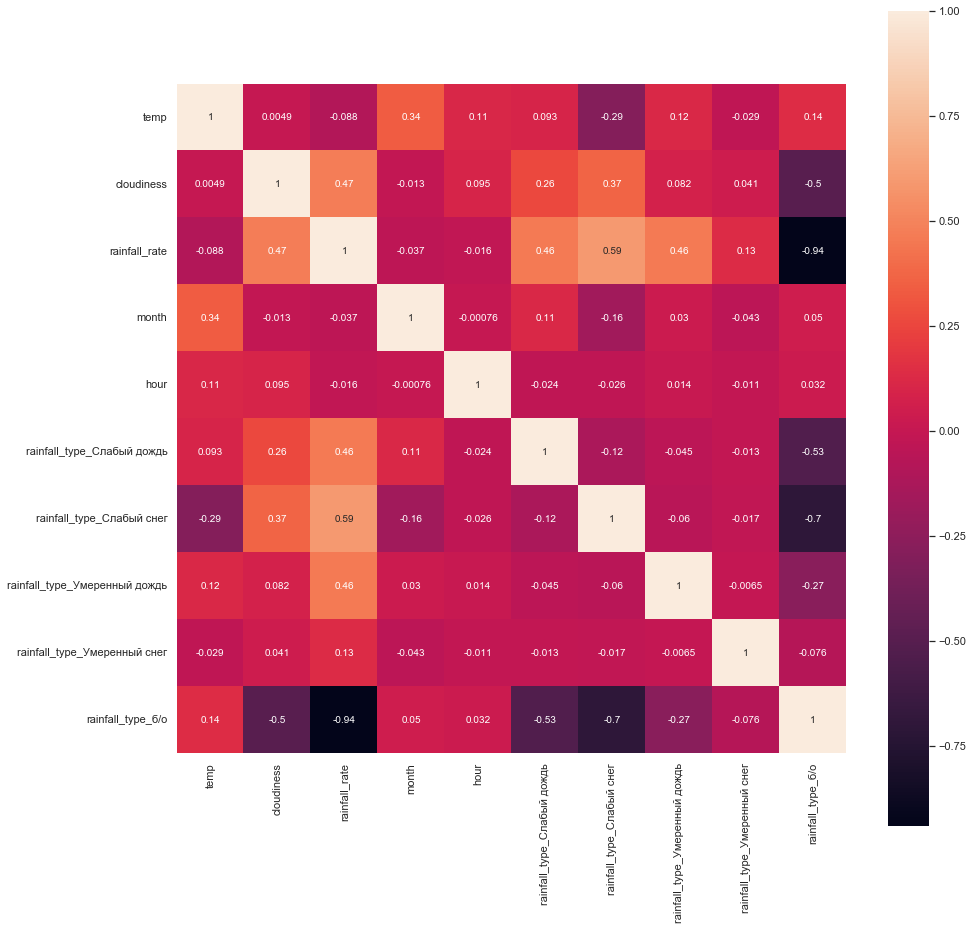

In [52]:
# корреляционная матрица
corr_m = X.corr()# напишите ваш код здесь

# нарисуем heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m,
            square = True, 
            annot = True)
plt.show()

Создаем модель RandomForestRegressor

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


Метрики на обучающей выборке
MAE: 0.01
MSE: 0.00
RMSE: 0.00
MAPE: 0.98
Метрики на тестовой выборке
MAE: 0.04
MSE: 0.01
RMSE: 0.01
MAPE: 0.85


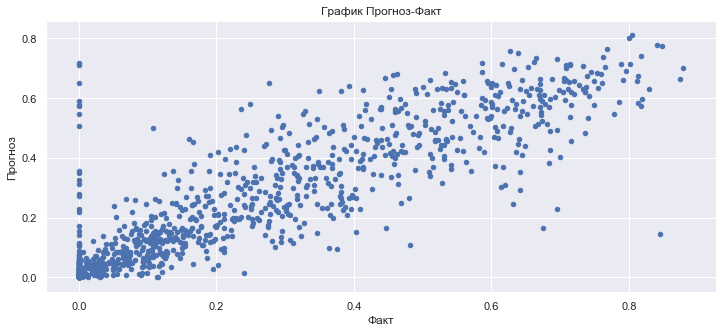

In [54]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# задаём алгоритм для модели 
model = RandomForestRegressor(random_state=0)

# обучим модель
model.fit(X_train_scaled, y_train.values.ravel())

# сделайте прогноз обученной моделью
predictions = model.predict(X_train_scaled)
predictions_test = model.predict(X_test_scaled) 

# выведем основные метрики
print('Метрики на обучающей выборке')
print('MAE: {:.2f}'.format(mean_absolute_error(y_train,predictions)))
print('MSE: {:.2f}'.format(mean_squared_error(y_train,predictions)))
print('RMSE: {:.2f}'.format(mean_squared_error(y_train,predictions)))
print('MAPE: {:.2f}'.format(r2_score(y_train,predictions)))

print('Метрики на тестовой выборке')
print('MAE: {:.2f}'.format(mean_absolute_error(y_test,predictions_test)))
print('MSE: {:.2f}'.format(mean_squared_error(y_test,predictions_test)))
print('RMSE: {:.2f}'.format(mean_squared_error(y_test,predictions_test)))
print('MAPE: {:.2f}'.format(r2_score(y_test,predictions_test)))


y_test['predictions'] = predictions_test
y_test.head()


fig, ax = plt.subplots(figsize=(12,5),
                       )
y_test.plot(x='load_rate', y='predictions', ax=ax, kind='scatter')
ax.set(title='График Прогноз-Факт', 
       xlabel='Факт', 
       ylabel='Прогноз')
ax.legend().set_visible(False)

Сохраняем модель в файл

In [55]:
filename = "E:\EZG\VIE\solar_rfr\solar_rfr.pickle"
# save model
pickle.dump(model, open(filename, "wb"))

Строим проноз на 27.02.2013 и сверяем его с фактическими значениями

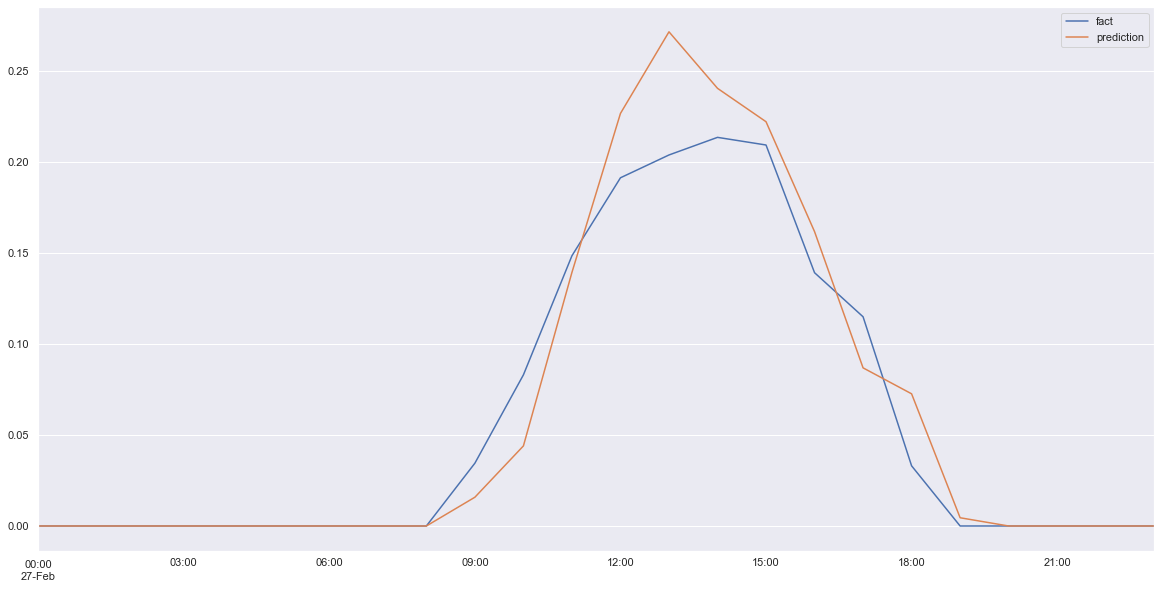

In [57]:
day_of_interest = '2023-02-27'
date_of_interest = last_four_days.query('@day_of_interest+"-00" <= date <= @day_of_interest+"-23"')

X_test = date_of_interest[[
         'temp', 
         'cloudiness', 
         'rainfall_rate', 
         'month', 
         'hour',
         'rainfall_type_Слабый дождь', 
         'rainfall_type_Слабый снег', 
         'rainfall_type_Умеренный дождь', 
         'rainfall_type_Умеренный снег', 
         'rainfall_type_б/о'
       ]]

X_test_scaled = ss.transform(X_test)

predictions_test = model.predict(X_test_scaled) 

results = pd.DataFrame({"fact": date_of_interest.load_rate.to_list(),
                        "prediction": predictions_test},
                        index = date_of_interest.date.to_list())

fig, ax = plt.subplots(figsize=(20,10)) 

results.plot(ax = ax) 

In [58]:
results['MAPE, %'] = 100*abs(results['fact'] - results['prediction'])/results['fact'].max()
print(f"MAPE за {day_of_interest}: {round(results['MAPE, %'].mean(),2)}%")

MAPE за 2023-02-27: 5.94%


**Вывод**

Создали модель на основе метода Random Forest Regresor. На тестовой дате средняя за 24 часа относительная ошибка прогнозирования составила 5,94 %. В дальнейшем протестируем модель на более длинном временном интервале.